In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

In [21]:
sample_freq = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 10.0  # in dB

wm = ss.WirelessMicrophone(f_sample=sample_freq,
                           t_sec=length)  # either specify length in seconds
# wm = ss.WirelessMicrophone(f_sample=sample_freq, num_samples=1e5) # or number of samples
sig = wm.get_signal(f_center=-1e5,
                    f_deviation=15000,
                    f_modulation=3900,
                    dB=-10)

sig += wm.get_signal(f_center=0e5,
                    f_deviation=15000,
                    f_modulation=3900,
                    dB=-5)

sig += wm.get_signal(f_center=1e5,
                    f_deviation=15000,
                    f_modulation=3900,
                    dB=0)

sig += wm.get_signal(f_center=2e5,
                    f_deviation=15000,
                    f_modulation=3900,
                    dB=5)

sig += wm.get_signal(f_center=3e5,
                    f_deviation=15000,
                    f_modulation=3900,
                    dB=10)

# print('wm.f_sample:     %6.2f' % (wm.f_sample))
# print('wm.num_samples:  %9d' % (wm.num_samples))
# print('wm.t_sec:        %6.2f' % (wm.t_sec))

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq,
                            t_sec=length)  # either specify length in seconds
# wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length) # or number of samples
noise = wgn.get_signal(dB=noise_strength)

# print('wgn.f_sample:    %6.2f' % (wgn.f_sample))
# print('wgn.num_samples: %9d' % (wgn.num_samples))
# print('wgn.t_sec:       %6.2f' % (wgn.t_sec))

assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power:    %6.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:     %6.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:             %6.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Mean:            %6.2f ' % (np.abs(noise.mean())))
print('Var:             %6.2f ' % (np.abs(noise.var())))
print('Num Samples:     %9d ' % (num_samples))

Signal power:     11.64 dB
Noise power:       9.99 dB
SNR:               1.65 dB
Mean:              0.00 
Var:               9.98 
Num Samples:       1000000 


KeyboardInterrupt: 

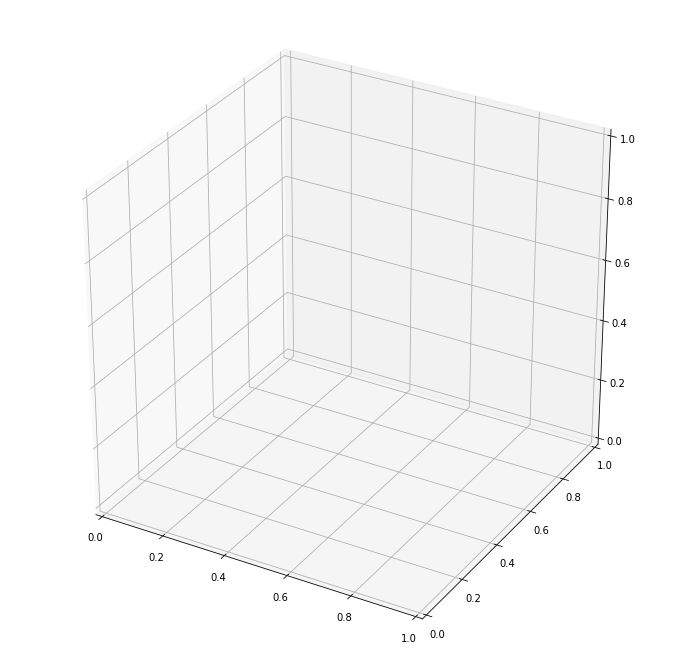

In [24]:
from scipy import fft
import scipy.ndimage
from mpl_toolkits import mplot3d as mpl3d
from matplotlib import cm

f, t, Sxx = signal.spectrogram(both,
                               sample_freq,
                               return_onesided=False,
                               window='hann',
                               nperseg=1024,
                               nfft=1024,
                               noverlap=0,
                               detrend=False,
                               scaling='density',
                               mode='psd')

f = fft.fftshift(f)
Sxx = fft.fftshift(Sxx, axes=0)

def clip_2d(x, lim_min, lim_max):
    (x, y) = np.shape(Sxx)
    for i in range(x):
        for j in range(y):
            Sxx[i, j] = max(min(Sxx[i, j], lim_max), lim_min)
    return Sxx


def smooth_2d(x, sigma):
    return scipy.ndimage.filters.gaussian_filter(x, [sigma, sigma],
                                                 mode='mirror')


def crop_2d(Sxx, f, t, n):
    Sxx = Sxx[n:-n, n:-n]
    f = f[n:-n]
    t = t[n:-n]
    return Sxx, f, t

Sxx = 10.0 * np.log10(Sxx)
Sxx = clip_2d(Sxx, -60, 0)
Sxx = smooth_2d(Sxx, 2)
# Sxx, f, t = crop_2d(Sxx, f, t, 4)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
# ax.get_proj = lambda: np.dot(mpl3d.axes3d.Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))
ax.plot_surface(f[:, None],
                t[None, :],
                Sxx,
                cmap='viridis',
                rstride=1,
                cstride=1,
                alpha=1,
                antialiased=True)
ax.view_init(elev=30, azim=70)
plt.show()
# plt.savefig('test.png')

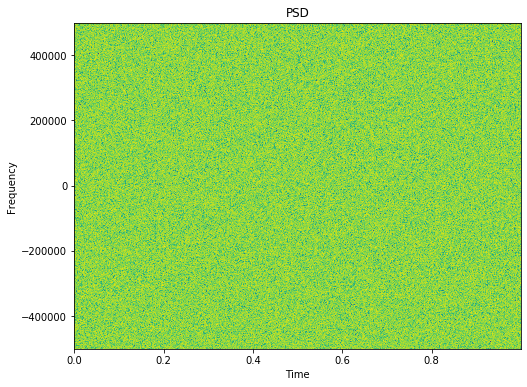

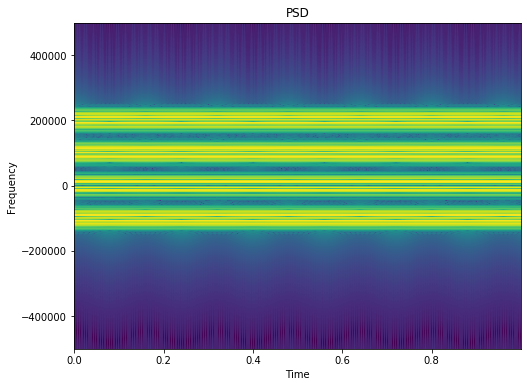

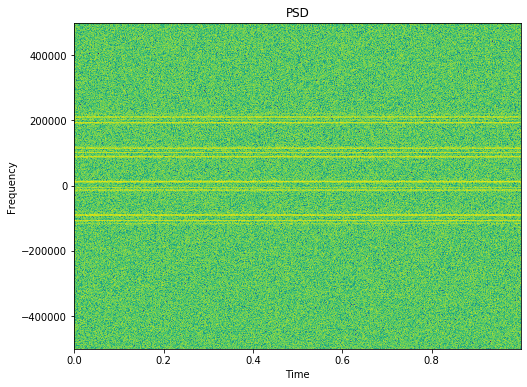

In [20]:
# Plot the resulting signals using matplotlib for comparison

plt.figure(figsize=(8, 6))
plt.specgram(noise,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(sig,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(both,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()